# Итоговое задание

# Морозова Маргарита, РИ-481223

### Вариант 12

In [186]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame
from spectrum import Periodogram
from scipy import signal
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot 
import h5py
import pywt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
%matplotlib inline

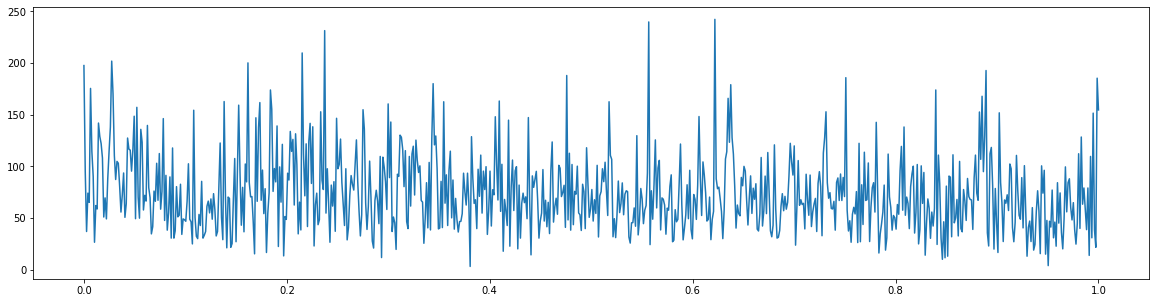

In [205]:
t = np.linspace(0, 1, 768)
F = np.genfromtxt(fname= r'C:\Users\Морозова Маргарита\Downloads\12.txt')
plt.figure(figsize= (20, 5))
plt.plot(t, F)

### Оцените мат. ожидание, дисперсию данных 

In [4]:
len (F)

768

In [5]:
M = np.mean(F)
D = np.var(F)
S = np.std (F)
V = S/M
print ('Коэффициент вариации:', V)
print ('Среднеквадратичное (стандартное) отклонение: ',S)
print ('Дисперсия: ', D)
print ('Мат. ожидание:', M)

Коэффициент вариации: 0.5077592979655808
Среднеквадратичное (стандартное) отклонение:  37.8059193436417
Дисперсия:  1429.2875374179414
Мат. ожидание: 74.45638020833333


Ряд у нас более менее однородный и имеет относительно небольшой разброс о чем свидетельствует коэффициент вариации.

Для более точной оценки стационарности можно применить тест Дики-Фуллера.

In [6]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(F)
print('p-value = ' + str(adf_test[1]))

p-value = 1.99726581629953e-06


Результат существенно меньше 5%. Временной ряд стационарен.

### Постройте периодограмму и спектрограмму выбранного ряда. Если в данных заметен четкий период – найдите и укажите его численно.

Оценка с помощью метода Велша (Welch):

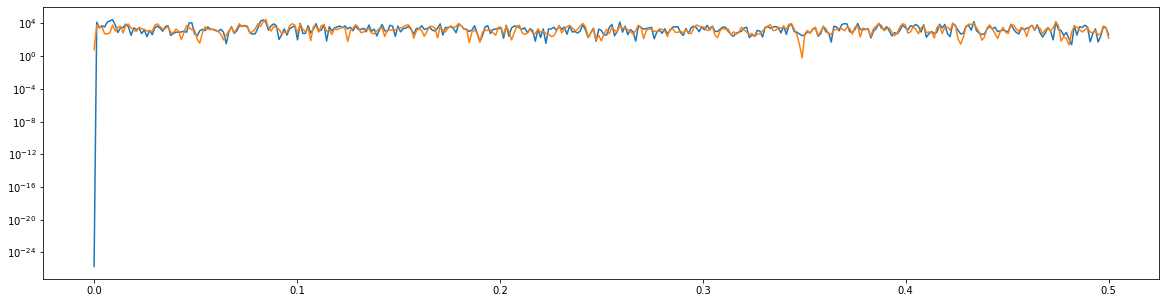

In [7]:
pd1, pdden1 = signal.periodogram(F)
pdw1, pddenw1 = signal.welch(F, nperseg = 768)
plt.figure(figsize = (20, 5))
plt.semilogy(pd1, pdden1)
plt.semilogy(pdw1, pddenw1)

Второй способ:

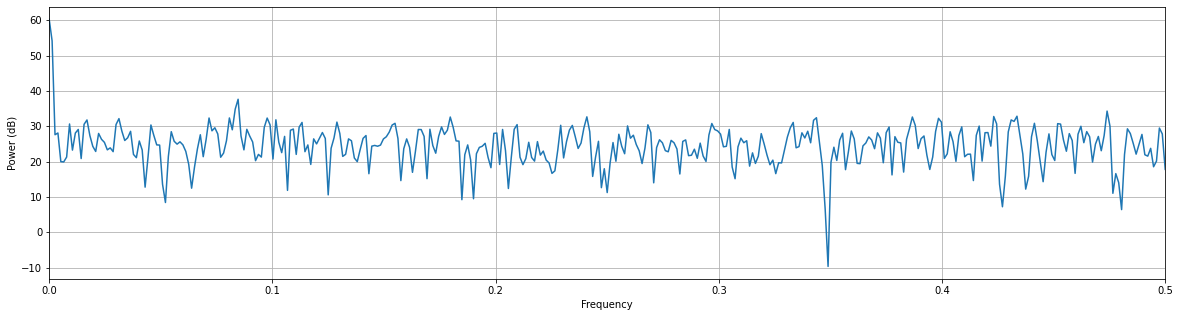

In [8]:
p = Periodogram(F)
plt.figure(figsize = (20, 5))
p.plot()

In [9]:
fs = 1/(t[1]-t[0])#fs = 1/dt = N/T

(0.0, 150.0)

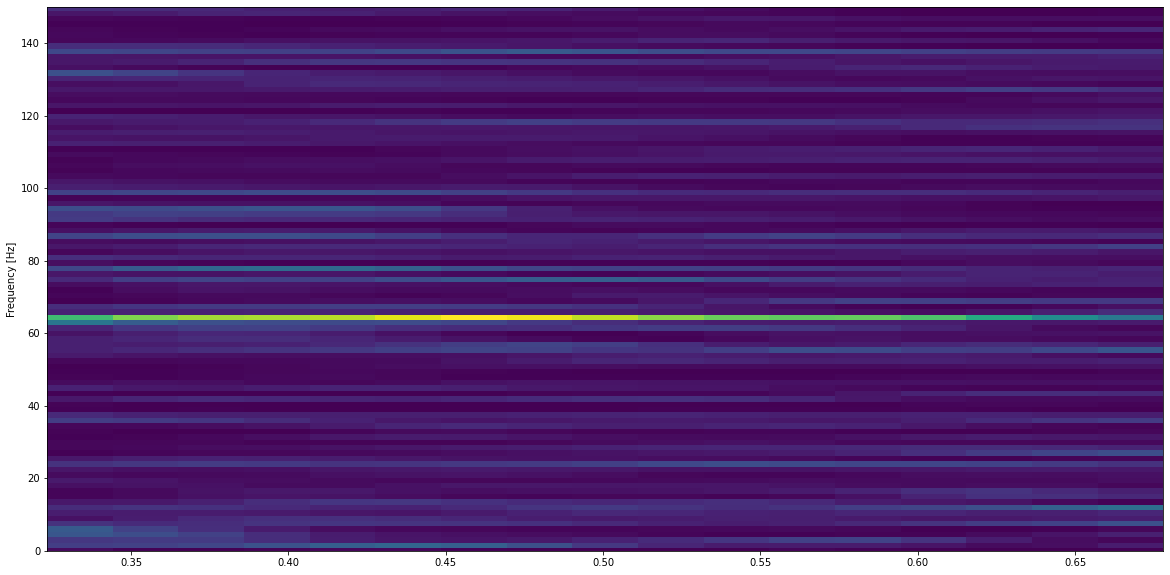

In [10]:
f, tx, Sxx= signal.spectrogram(F, fs, nperseg= 512, noverlap= 496, nfft=512)
plt.figure(figsize= (20, 10))
plt.pcolormesh(tx, f, Sxx, shading='auto' )
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 150) 

Получаем картину, по которой в принципе можно различить 1 постоянную периодику в районе 65. Зависимости от времени нет.

### Постройте наиболее подходящий тренд для данных.

Построим тренд 1 порядка.

In [11]:
X = np.hstack((np.ones(768).reshape(768, 1), t.reshape(768, 1)))
F = F.reshape(768, 1)
B = np.linalg.lstsq(X, F, rcond=None)

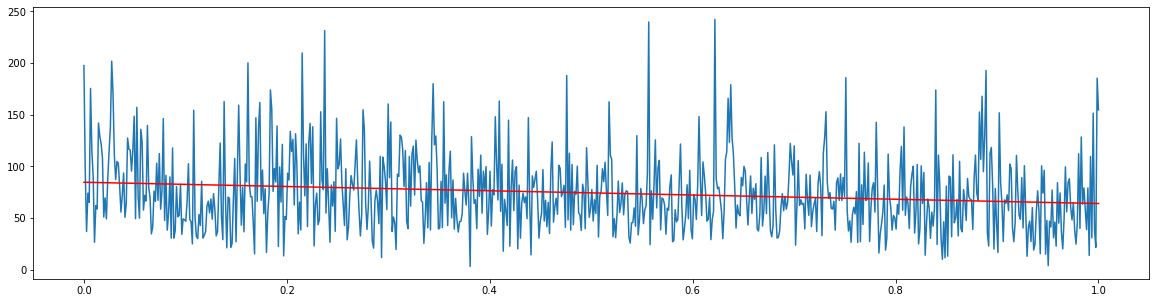

In [12]:
B= B[0]#забираем из результата коэффициенты βprint(B)
plt.figure(figsize = (20, 5))
plt.plot(t, F) # строимисходныйВР
plt.plot(t, B[0] + B[1] * t, 'r')# строим его тренд
plt.show()

Видим, что все-таки, есть нисходящий тренд (что было неочевидно, на первый взгляд)

Попробуем построить тренд 2 степени.

[[ 85.76963674]
 [-26.75234385]
 [  6.18471443]]


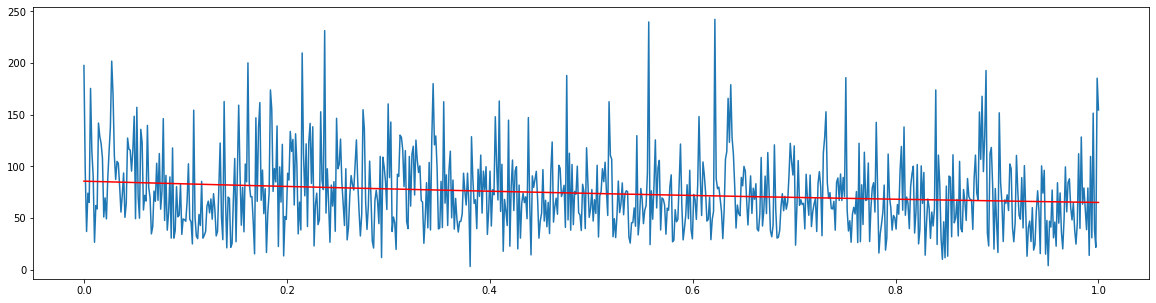

In [13]:
X2 = np.hstack((X, np.power(t, 2).reshape(768, 1)))
F = F.reshape(768, 1)
B = np.linalg.lstsq(X2, F, rcond=None)

plt.figure(figsize=(20, 5))
B = B[0] # забираем из результата коэффициенты β
print(B)
plt.plot(t, F) # строим исходный ВР
plt.plot(t, B[0] + B[1] * t + B[2] * t ** 2, 'r') # строим его тренд

Видим, что наиболее оптимальным для данного ряда является тренд 1 порядка.

### Постройте прогноз этого тренда с помощью методов регрессии. 

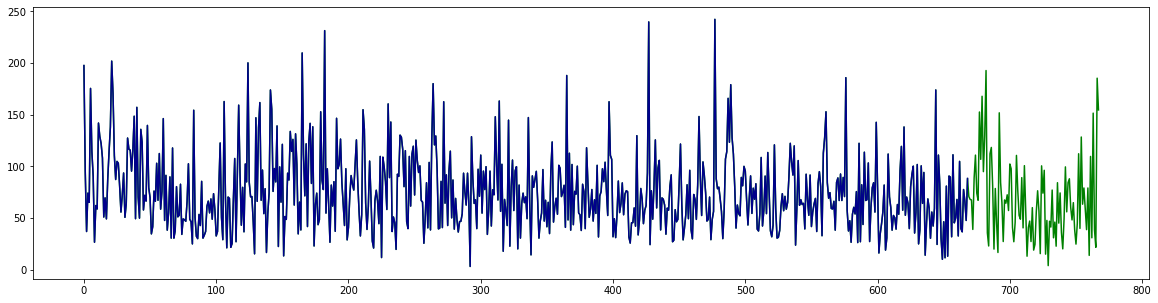

In [14]:
Z= F[:len(F)-100+1] # отрезаем последние 100 точек
t=np.arange(0, len(Z), 1) # временная шкала для регрессии
t=t.reshape(-1,1)
plt.figure(figsize = (20, 5))
plt.plot(F, 'g') # исходныйВР
plt.plot(t, Z, 'darkblue') # урезанныйряд
plt.show()

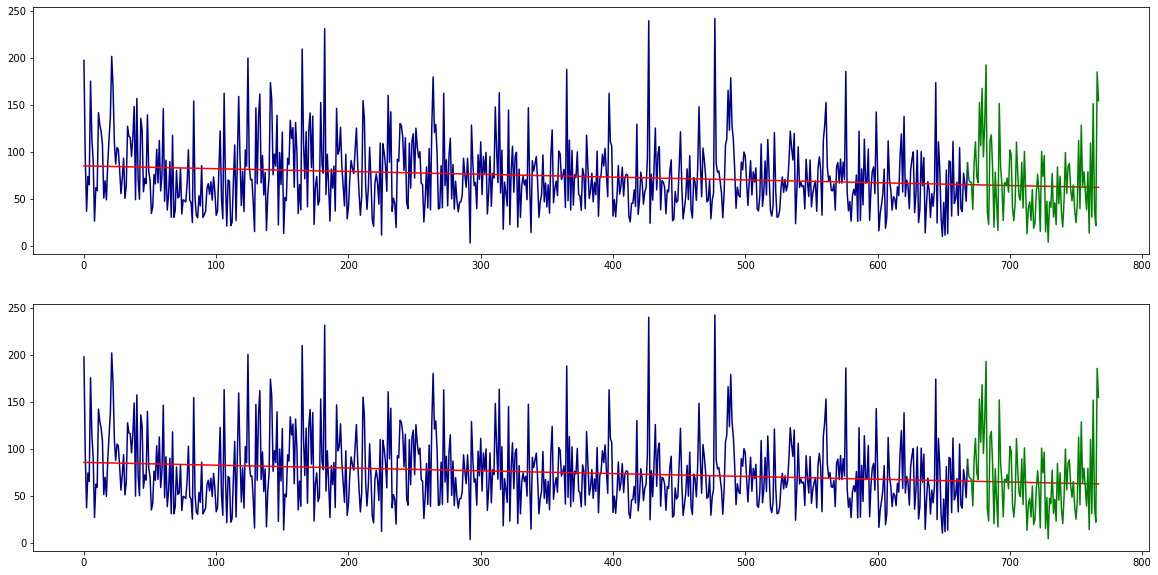

In [15]:
plt.figure(figsize=(20, 10))

plt.subplot(211)
t=np.arange(0, len(Z), 1)# диапазон урезанного ряда
t=t.reshape(-1,1)
t0=np.arange(0, len(F), 1)# диапазонполногоряда
t0=t0.reshape(-1,1)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(t, Z)#модельрегрессии
plt.plot(t, Z, 'darkblue')
plt.plot(t0, reg.predict(t0), 'r')# прогнознавесьдиапазон
plt.plot(t0[-100:], F[-100:], 'g') # реальные прогнозные значения

plt.subplot(212)
def func(t, b0, b1):return b0 + b1 * t
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, t.reshape(1,-1)[0], Z.reshape(1,-1)[0])
plt.plot(t, Z, 'darkblue')
ZZ1 = t0*popt[1]+popt[0]
plt.plot(t0, ZZ1, 'r')
plt.plot(t0[-100:], F[-100:], 'g')


In [16]:
t=t.reshape(-1,1)
trend_1=lambda s: s*popt[1]+popt[0]
delta_1=[]
S=np.sqrt(np.sum((Z-trend_1(t))**2)/(len(Z)-2))
for l in range (-1, 99):
    g=1.96*S*np.sqrt(1+(1/len(Z))+(trend_1(t0[len(Z)+l])-np.mean(trend_1(t)))/np.sum((trend_1(t)-np.mean(trend_1(t)))**2))
    delta_1.append(g[0])

In [17]:
def Interval(trend, delta):  
    
    upper_limits=trend(t0[-100:]) + np.array(delta).reshape(-1,1)
    lower_limits=trend(t0[-100:]) - np.array(delta).reshape(-1,1)

    plt.plot(t, Z, 'darkblue') 
    plt.plot(t0, trend(t0), 'r') 
    plt.plot(t0[-100:], F[-100:], 'k') 
    plt.plot(t0[-100:], upper_limits, 'g')
    plt.plot(t0[-100:], lower_limits, 'g')

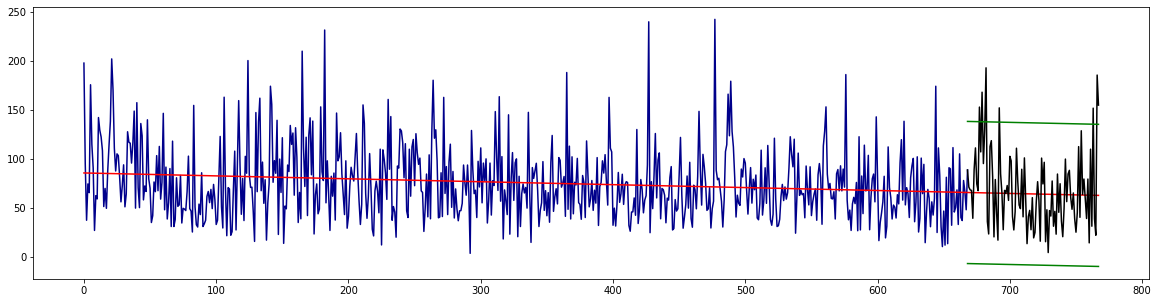

In [18]:
plt.figure(figsize=(20, 5))
Interval (trend_1, delta_1)

### Постройте прогноз данных с помощью ARIMA модели.

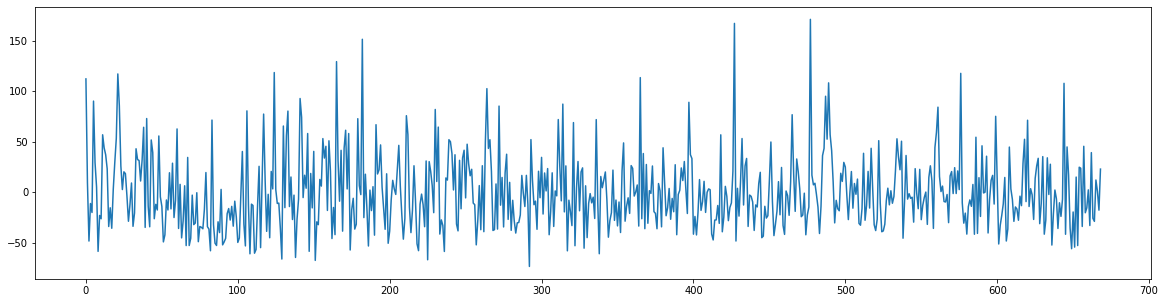

In [19]:
ZZ = Z - ZZ1[:-99] # Тренд-стационарная форма
plt.figure(figsize = (20, 5))
plt.plot(t0[:-99], ZZ)

In [20]:
import itertools    
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

In [67]:
for param in pdq:
            mod = sm.tsa.statespace.SARIMAX(ZZ, order = param, enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{} - AIC:{} - BIC:{}'.format(param, results.aic, results.bic))   

ARIMA(0, 0, 0) - AIC:6712.151943617191 - BIC:6716.656231790727
ARIMA(0, 0, 1) - AIC:6702.26994862163 - BIC:6711.275528713461
ARIMA(0, 0, 2) - AIC:6687.120080418492 - BIC:6700.623949430113
ARIMA(0, 1, 0) - AIC:7117.200464547985 - BIC:7121.7032545939
ARIMA(0, 1, 1) - AIC:6701.207838162013 - BIC:6710.210417503094
ARIMA(0, 1, 2) - AIC:6691.374788238063 - BIC:6704.874149360031
ARIMA(0, 2, 0) - AIC:7844.155802528326 - BIC:7848.657092198866
ARIMA(0, 2, 1) - AIC:7105.393477266236 - BIC:7114.393051347548
ARIMA(0, 2, 2) - AIC:6695.92790077769 - BIC:6709.42274722612
ARIMA(1, 0, 0) - AIC:6710.856631313088 - BIC:6719.865207660161
ARIMA(1, 0, 1) - AIC:6701.643978878719 - BIC:6715.152349016466
ARIMA(1, 0, 2) - AIC:6688.748205469656 - BIC:6706.753364151818
ARIMA(1, 1, 0) - AIC:6920.293543945609 - BIC:6929.29912403744
ARIMA(1, 1, 1) - AIC:6699.602981234606 - BIC:6713.106850246227
ARIMA(1, 1, 2) - AIC:6694.311378764963 - BIC:6712.310526927586
ARIMA(1, 2, 0) - AIC:7420.785131620519 - BIC:7429.78771096159

Оптимальные параметры - ARIMA(2, 0, 0) - AIC:6699.175175304365 - BIC:6712.6835454421125 (Выбираем по параметру BIC, так как данный  критерий  налагает  больший  штраф  на увеличение количества параметров по сравнению с AIC)
Так ка ряд стационарен, выбираем модель, в которой d = 0.

In [21]:
arimaz = sm.tsa.arima.ARIMA(ZZ, order = (2, 0, 0)) 
model_fit = arimaz.fit() # подгоняем под ВР 
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  669
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -3360.271
Date:                Sat, 25 Jun 2022   AIC                           6728.541
Time:                        00:41:55   BIC                           6746.564
Sample:                             0   HQIC                          6735.523
                                - 669                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0128      1.959      0.007      0.995      -3.827       3.852
ar.L1          0.0647      0.039      1.664      0.096      -0.012       0.141
ar.L2          0.0836      0.043      1.960      0.0

In [22]:
model_fit.plot_predict(0, len(F)) 

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

Возникла ошибка, скорее всего, связанная с версиями, однако, после обновления statsmodels, ошибка не исчезла.
Попробуем исправить другими способами.

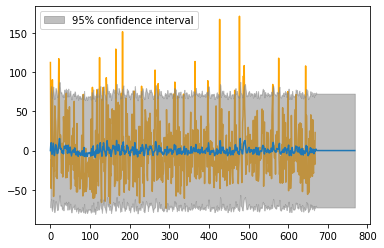

In [23]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model_fit, 0 ,len(F))
plt.plot(t0[:-99], ZZ, 'orange', zorder=-1) 

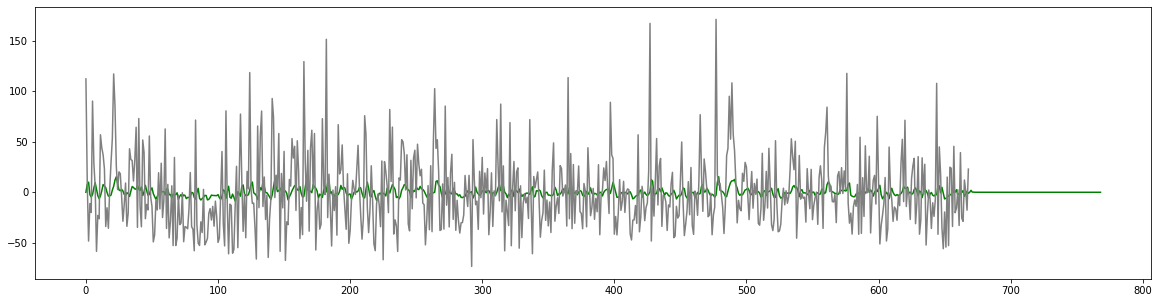

In [24]:
plt.figure(figsize=(20, 5))
pred = model_fit.predict(0, len(F)) 
plt.plot(pred, 'g') 
plt.plot(t0[:-99], ZZ, 'grey') 
plt.show()

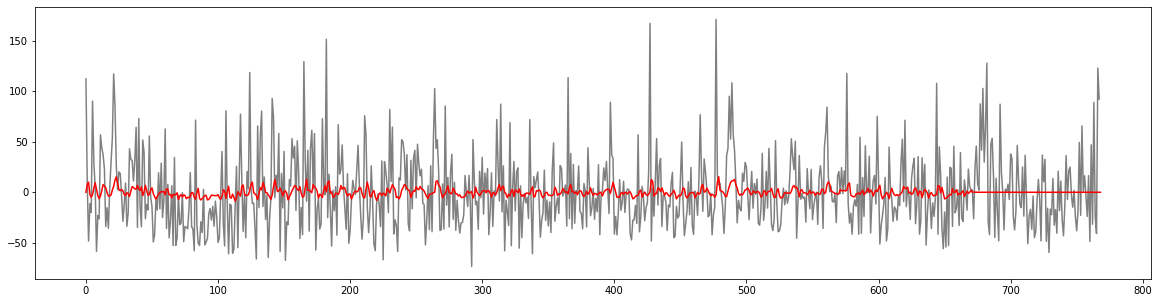

In [25]:
plt.figure(figsize = (20, 5))
pred1 = model_fit.predict(0, len(F)) 
plt.plot(t0, F-ZZ1, 'grey') # исходный ВР минус тренд
plt.plot(pred1, 'r')
plt.show()

Видим, что модель ARIMA не подходит для данного ряда. Прогноз вообще получился линейный.

### Если в ряде отсутствуют явные периодические составляющие –постройте тренд с помощью методов вейвлет-анализа и SSA

Поппробуем построить тркнд, используя разные виды базового вейвлета, а также разные уровни декомпозиции.

In [26]:
wvlt = pywt.Wavelet('haar')
pywt.dwt_max_level(len(F), wvlt) 

9

C:\Users\Морозова Маргарита\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


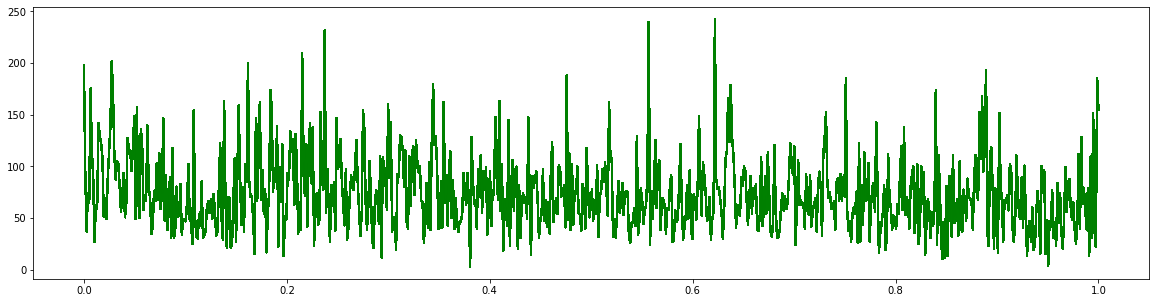

In [27]:
cA8, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(F, wvlt, level=8)

t = np.linspace(0, 1, 768)
F = F.reshape(768, 1)
Fre = pywt.waverec((cA8, cD8, None, None, None, None, None, None, None), wvlt)

plt.figure(figsize = (20, 5))
plt.plot(t, F, 'k')
plt.plot(t, Fre[-1024:], 'g')
plt.show()

In [28]:
wvlt = pywt.Wavelet('db6')
pywt.dwt_max_level(len(F), wvlt) 

6

C:\Users\Морозова Маргарита\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


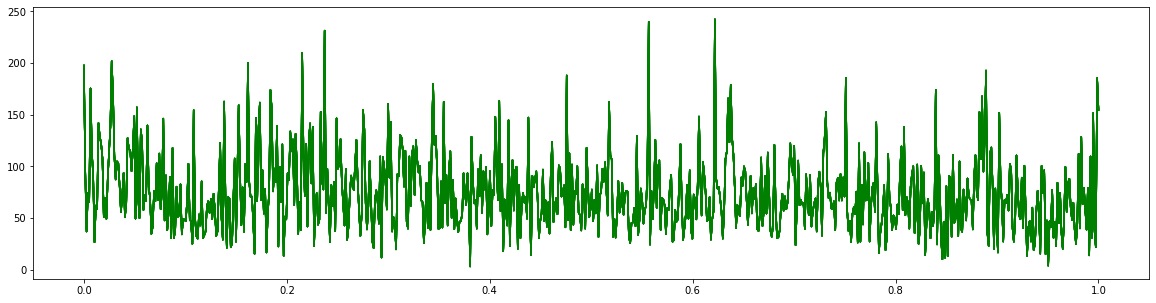

In [184]:
cA5, cD5, cD4, cD3, cD2, cD1 = pywt.wavedec(F, wvlt, level=5)

t = np.linspace(0, 1, 768)
F = F.reshape(768, 1)
Fre = pywt.waverec((cA5, None, None, None, None, None), wvlt)

plt.figure(figsize = (20, 5))
plt.plot(t, F, 'k')
plt.plot(t, Fre[-1024:], 'g')
plt.show()

### Постройте прогноз ряда с помощью рекурсивного метода Сингулярного Спектрального Анализа SSA-R.

In [30]:
def SSA_modes(F, L):
  
    N = len(F)
    K = N - L + 1
    X = np.empty((L, K))
    
    for i in range (L):
        for j in range (K):
            X[i][j] = F[i+j]
            
    S = np.dot(X, X.T)    
    U, A, _ = np.linalg.svd(S) 
    V = np.dot(X.T, U) 
    
    return A, U, V # где A - массив собственных чисел, U - матрица собственных векторов, V - матрица траекторных векторов.

In [31]:
def SSA_group(A, U, V, N, I):

    L = len(A)
    K = N - L + 1
    
    V = V.transpose()
    Z = np.dot(U[:, I], V[I, :]) 
    
    G = np.zeros(N) 
    Lmin = min(L, K)
    Kmax = max(L, K)
    for k in range(N):
        g=0
        if (k < Lmin - 1):
            for m in range (0, k+1):
                g = g + Z[m][k-m]
            G[k] = g / (k+1)
            
        elif (k < Kmax):
            for m in range (0, Lmin):
                g = g + Z[m][k-m]
            G[k] = g / Lmin
            
        elif (k < N + 1):
            for m in range (k-Kmax+1, N-Kmax+1):
                g = g + Z[m][k-m]
            G[k] = g / (N-k)
            
    return G # G - массив отсчетов восстановленного ряда

In [32]:
def SSA_R (F, L, I, M):
    
    N = len(F)
    A, U, V = SSA_modes(F, L)
    G = SSA_group(A, U, V, len(F), I)
    
    vu = np.linalg.norm(U[-1, I])
    R = np.sum(U[L - 1, I] * U[0:L - 1, I], 1)
    R = R / (1 - vu * vu)
    Q = np.zeros(N+M)
    for i in range (N+M):
        q=0
        if (i < N):
            Q[i] = G[i]
        else:
            for j in range(L-2):
                q = q + R[j]*Q[i-j-1]
            Q[i] = q
            
    return Q

In [143]:
Z = F[:len(F)-100+1] 
t=np.arange(0, len(Z), 1) 
plt.figure(figsize = (20, 5))

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

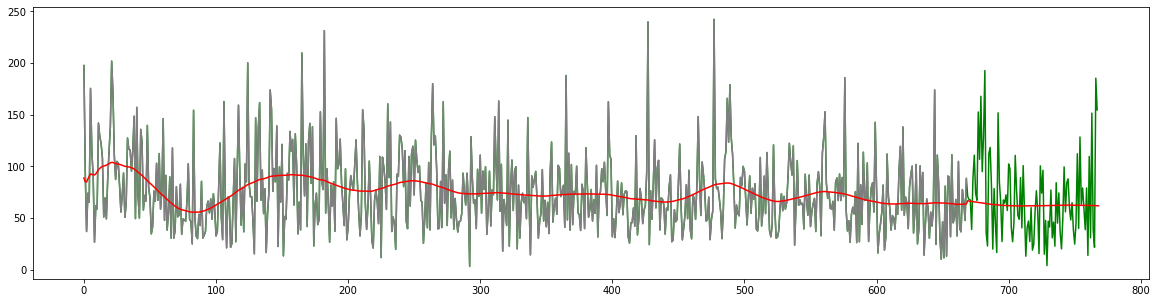

In [145]:
Q = SSA_R(Z, 100, [0, 3, 4], 100)

plt.figure(figsize = (20, 5))
plt.plot(F, 'g')
plt.plot(t, Z, 'grey')
plt.plot(Q,'r')

Для более точного прогноза будем изменять входные параметры (L - уменьшать, I)

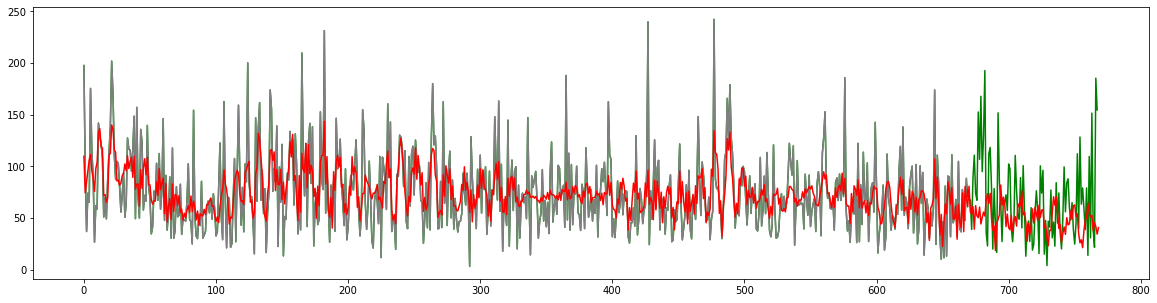

In [181]:
Q = SSA_R(Z, 50, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 100)

plt.figure(figsize = (20, 5))
plt.plot(F, 'g')
plt.plot(t, Z, 'grey')
plt.plot(Q,'r')

Оптимальный результат ,который удалось получить, достигли при входных параметрах - (Z, 50, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 100)

### Постройте прогноз данных с помощью нейронной сети LSTM.

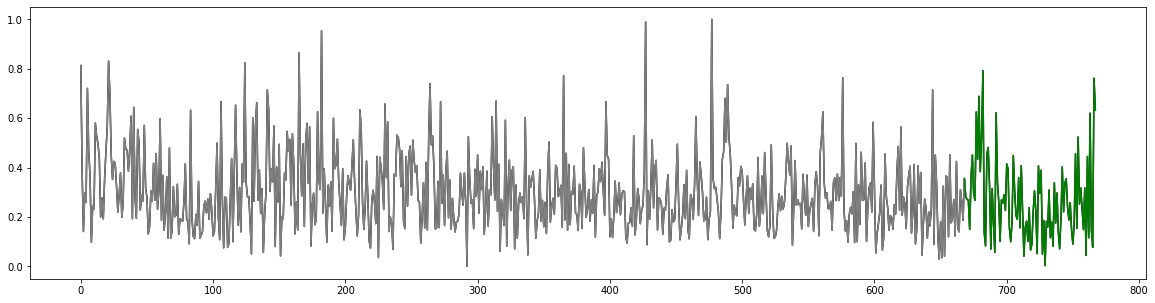

In [276]:
t = np.linspace(0, 1, 768)
Fort = np.genfromtxt(fname= r'C:\Users\Морозова Маргарита\Downloads\12.txt')
F = Fort
F = F.reshape(768, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
F = scaler.fit_transform(F)
F_tr = F[:678]
F_test = F[668:]
plt.figure(figsize = (20, 5))
plt.plot(F, 'k')
plt.plot(np.r_[:678],F_tr, 'grey')
plt.plot(np.r_[668:768],F_test, 'g')
plt.show()

In [287]:
from keras.preprocessing.sequence import TimeseriesGenerator
data_gen = TimeseriesGenerator(F_tr, F_tr,length=10, sampling_rate=1, batch_size=678)
batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
print(x.shape) # 144 точки обучения, прогноз 1 точки по 6 прошлым
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y
print(xx.shape) # меняем местами размерности
print(yy.shape) #

(668, 10, 1)
(668, 1, 10)
(668, 1)


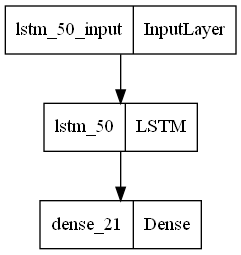

In [290]:
from keras.utils import plot_model
model = Sequential() # слои соединены последовательно
model.add(LSTM(units=30, input_shape=(1, 10))) # 30 нейронов
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'Nadam', loss = 'mean_squared_error')
plot_model(model, to_file='model.png') # рисунок полученной сети

In [291]:
model.fit(xx, yy, epochs = 100) # 100 эпох по 144 точки

Epoch 1/100
21/21 [==============================] - 4s 5ms/step - loss: 0.0711
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0316
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0248
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0246
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0245
Epoch 7/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0244
Epoch 8/100
21/21 [==============================] - 0s 8ms/step - loss: 0.0242
Epoch 9/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0241
Epoch 10/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0240
Epoch 11/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0239
Epoch 12/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0239
Epoch 13/100
21/21 [================

21/21 [==============================] - 1s 3ms/step


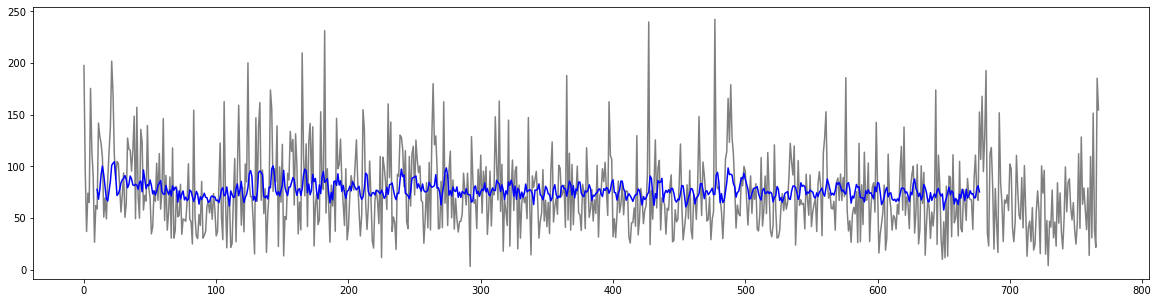

In [292]:
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict)
plt.figure(figsize = (20, 5))
plt.plot(Fort, 'grey')
plt.plot(np.r_[10:678],trainPredict, 'b')
plt.show()

In [293]:
data_gen = TimeseriesGenerator(F_test, F_test,length=10, sampling_rate=1, batch_size=768)
batch_0 = data_gen[0]
x, y = batch_0
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) 
print(yy.shape) 

(90, 1, 10)
(90, 1)


3/3 [==============================] - 0s 5ms/step


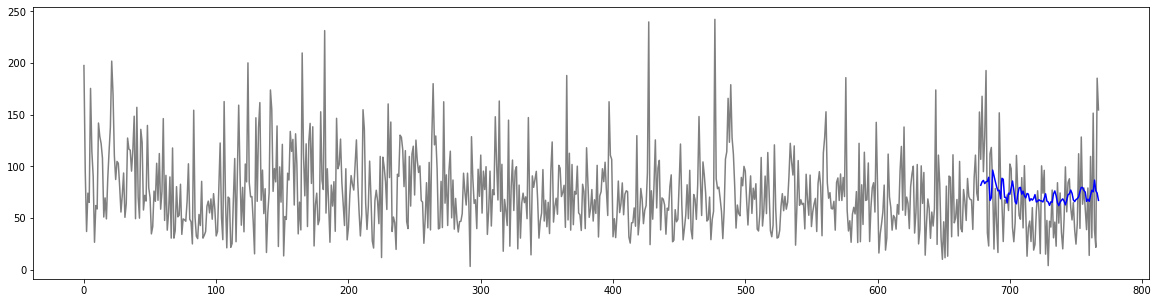

In [294]:
testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict)
plt.figure(figsize = (20, 5))
plt.plot(Fort, 'grey')
plt.plot(np.r_[678:768],testPredict, 'b')
plt.show()